In [38]:
# Se estiver rodando em um Colab, descomente a linha abaixo
# !pip install -r requirements.txt

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Oculta warnings do notebook
# import warnings
# warnings.filterwarnings('ignore')

# Configurações de visualização
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:,.2f}'.format

In [13]:
dataset_path = 'datasets/'
df = pd.read_csv(f"{dataset_path}consulta_cand_2022_SP.csv", sep=';')
print(df.shape)
df.info()

(3659, 71)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3659 entries, 0 to 3658
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DT_GERACAO                     3659 non-null   object 
 1   HH_GERACAO                     3659 non-null   object 
 2   ANO_ELEICAO                    3659 non-null   int64  
 3   CD_TIPO_ELEICAO                3659 non-null   int64  
 4   NM_TIPO_ELEICAO                3659 non-null   object 
 5   NR_TURNO                       3659 non-null   int64  
 6   CD_ELEICAO                     3659 non-null   int64  
 7   DS_ELEICAO                     3659 non-null   object 
 8   DT_ELEICAO                     3659 non-null   object 
 9   TP_ABRANGENCIA                 3659 non-null   object 
 10  SG_UF                          3659 non-null   object 
 11  SG_UE                          3659 non-null   object 
 12  NM_UE                          3659 n

In [16]:
df.DS_SIT_TOT_TURNO.value_counts()

SUPLENTE            1921
NÃO ELEITO          1381
#NULO#               184
ELEITO POR QP        142
ELEITO POR MÉDIA      22
ELEITO                 5
2º TURNO               4
Name: DS_SIT_TOT_TURNO, dtype: int64

In [24]:
elected_values = ['ELEITO POR QP', 'ELEITO POR MÉDIA', 'ELEITO']
fed_df = df.loc[
    (df['DS_CARGO'] == 'DEPUTADO FEDERAL') & 
    (df['DS_SIT_TOT_TURNO'].isin(elect_values))
]
print(fed_df.shape)

est_df = df.loc[
    (df['DS_CARGO'] == 'DEPUTADO ESTADUAL') & 
    (df['DS_SIT_TOT_TURNO'].isin(elect_values))
]
print(est_df.shape)

(70, 71)
(94, 71)


In [34]:
print(fed_df.DS_GENERO.value_counts())
print(fed_df.DS_COR_RACA.value_counts())
print(est_df.DS_GENERO.value_counts())
print(est_df.DS_COR_RACA.value_counts())

MASCULINO    56
FEMININO     14
Name: DS_GENERO, dtype: int64
BRANCA      59
PARDA        5
PRETA        3
INDÍGENA     2
AMARELA      1
Name: DS_COR_RACA, dtype: int64
MASCULINO    69
FEMININO     25
Name: DS_GENERO, dtype: int64
BRANCA    76
PARDA      9
PRETA      9
Name: DS_COR_RACA, dtype: int64


<AxesSubplot: xlabel='DS_COR_RACA', ylabel='Count'>

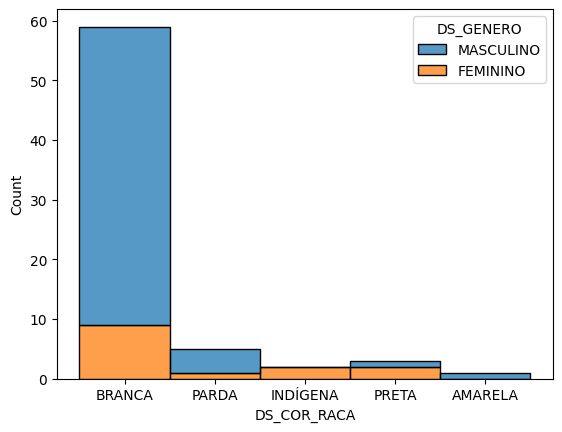

In [32]:
sns.histplot(
    data=fed_df,
    hue='DS_GENERO',
    x='DS_COR_RACA',
    multiple='stack',
)

<AxesSubplot: xlabel='DS_COR_RACA', ylabel='Count'>

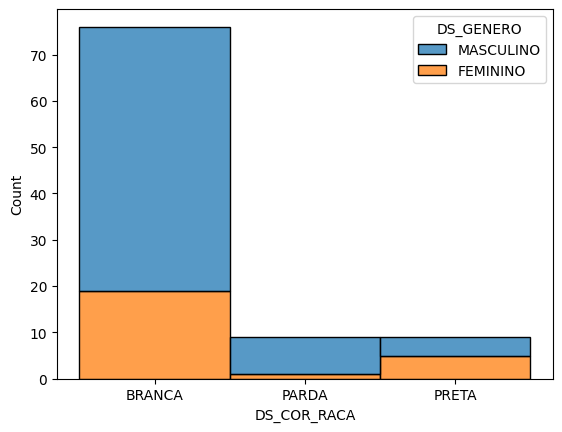

In [33]:
sns.histplot(
    data=est_df,
    hue='DS_GENERO',
    x='DS_COR_RACA',
    multiple='stack',
)